In [94]:
# Sam's Fans Fundraising Data Analysis Notebook

# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
# Set styles
sns.set(style="whitegrid")

In [84]:
# 2. Load Data
# Updated to load CSV file
# Ensure Donation_Data.csv is in the same directory

data = pd.read_csv('Donar_Data.csv', dtype={'Date': str})

data.head()

,Account Number,Date,Revenue Amount,Type,Fund,Campaign,Appeal,Primary City,Primary State,Primary ZIP Code
0,8231,2/18/25,$20.76,Recurring Donation Payment,Unrestricted,NaN,NaN,Columbus,OH,43214-4014
1,2139,2/17/25,$78.30,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Galena,OH,43021
2,1566,2/15/25,$52.30,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Darien,CT,06820-3204
3,10382,2/15/25,$21.11,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Columbus,OH,43214
4,9739,2/15/25,$24.23,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,BTJ Website,Dublin,OH,43017


In [86]:
# 3. Quick Data Check
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9488 entries, 0 to 9487
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Account Number    9488 non-null   int64 
 1   Date              9488 non-null   object
 2   Revenue Amount    9304 non-null   object
 3   Type              9488 non-null   object
 4   Fund              9488 non-null   object
 5   Campaign          6111 non-null   object
 6   Appeal            3418 non-null   object
 7   Primary City      8993 non-null   object
 8   Primary State     8974 non-null   object
 9   Primary ZIP Code  8987 non-null   object
dtypes: int64(1), object(9)
memory usage: 741.4+ KB


,Account Number
count,9488.000000
mean,4062.043107
std,4038.607020
min,4.000000
25%,723.000000
50%,1841.500000
75%,8830.250000
max,10827.000000


In [88]:
# 4. Clean and Prepare Data
# Assume columns like: 'Donor ID', 'Amount', 'Date', 'Campaign', 'Recurring Payment?'


# 2. Parse Date column correctly (flexible format)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# 3. Check first 10 dates
print(data['Date'].head(10))

# 4. Now create YearMonth
data['YearMonth'] = data['Date'].dt.to_period('M')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month


0   2025-02-18
1   2025-02-17
2   2025-02-15
3   2025-02-15
4   2025-02-15
5   2025-02-15
6   2025-02-15
7   2025-02-14
8   2025-02-13
9   2025-02-12
Name: Date, dtype: datetime64[ns]


/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/1118169147.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


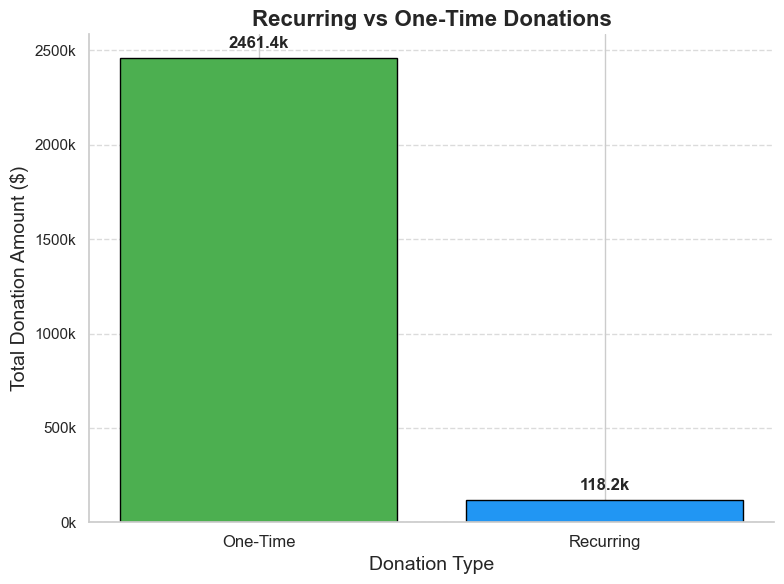

In [90]:
# 1. Clean Revenue Amount properly
data['Revenue Amount'] = data['Revenue Amount'].replace(r'[\$,]', '', regex=True).astype(float)

# 2. Simplify donation types
def categorize_type(x):
    if 'Recurring' in str(x):
        return 'Recurring'
    else:
        return 'One-Time'

data['Donation Type'] = data['Type'].apply(categorize_type)

# 3. Group
recurring_summary = data.groupby('Donation Type')['Revenue Amount'].sum()

# 4. Plot (visually enhanced)
fig, ax = plt.subplots(figsize=(8,6))

bars = ax.bar(recurring_summary.index, 
               recurring_summary.values, 
               color=['#4CAF50', '#2196F3'],  # Green and Blue
               edgecolor='black')

# Title and labels
ax.set_title('Recurring vs One-Time Donations', fontsize=16, fontweight='bold')
ax.set_xlabel('Donation Type', fontsize=14)
ax.set_ylabel('Total Donation Amount ($)', fontsize=14)

# Y-axis in thousands (e3)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height/1000:.1f}k', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 5), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Make x-axis labels horizontal
plt.xticks(rotation=0, fontsize=12)

# Add grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


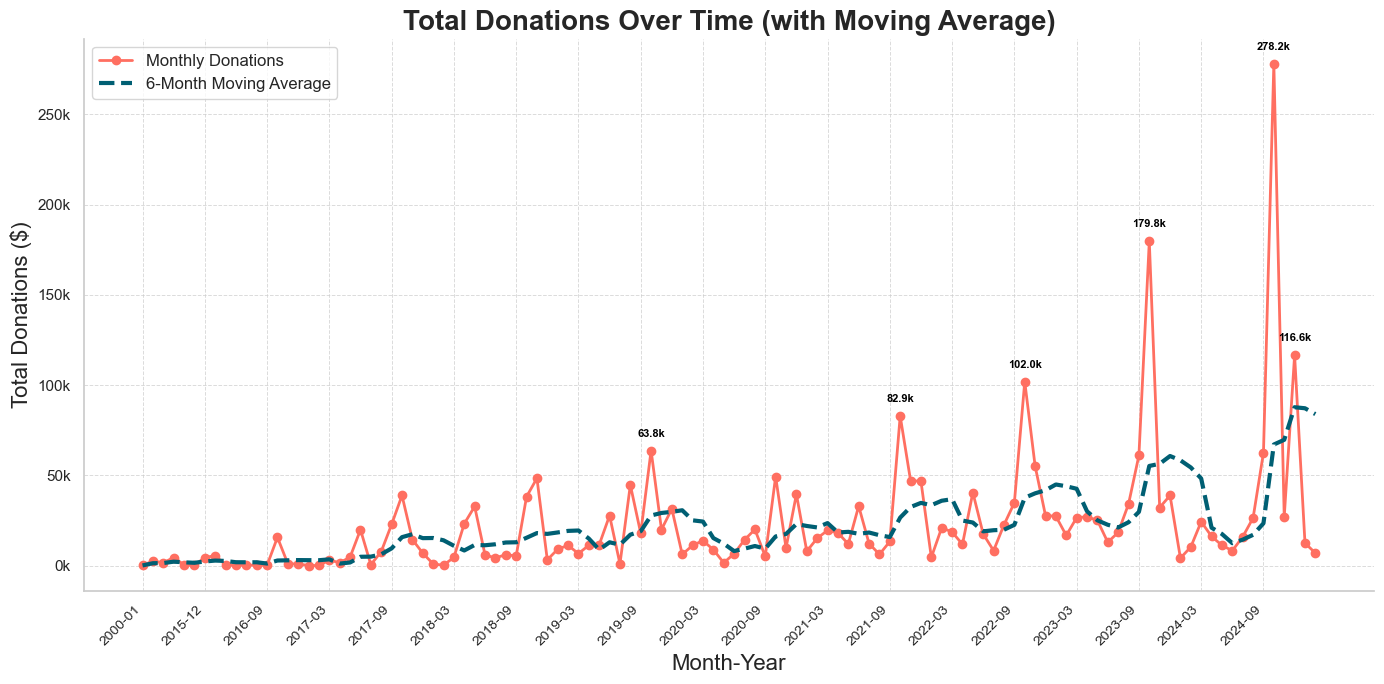

In [96]:
# 1. Group monthly donations
monthly_donations = data.groupby('YearMonth')['Revenue Amount'].sum().reset_index()

# 2. Calculate Moving Average (6-month rolling)
monthly_donations['6_Month_MA'] = monthly_donations['Revenue Amount'].rolling(window=6, min_periods=1).mean()

# 3. Plot
fig, ax = plt.subplots(figsize=(14, 7))

# Main donations line
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['Revenue Amount'], 
        marker='o', 
        linestyle='-', 
        color='#FF6F61', 
        linewidth=2, 
        label='Monthly Donations')

# Moving Average line
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['6_Month_MA'], 
        color='#005f73', 
        linewidth=3, 
        linestyle='--', 
        label='6-Month Moving Average')

# Title and labels
ax.set_title('Total Donations Over Time (with Moving Average)', fontsize=20, fontweight='bold')
ax.set_xlabel('Month-Year', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

# Format Y-axis in Thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Fix X-axis: show label every 6 months
step = 6
plt.xticks(ticks=range(0, len(monthly_donations), step), 
           labels=monthly_donations['YearMonth'].astype(str)[::step], 
           rotation=45, ha='right', fontsize=10)

# Grid
ax.grid(visible=True, linestyle='--', linewidth=0.7, alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# OPTIONAL: Annotate only very high spikes
threshold = monthly_donations['Revenue Amount'].quantile(0.95)
for i, row in monthly_donations.iterrows():
    if row['Revenue Amount'] >= threshold:
        ax.annotate(f'{row['Revenue Amount']/1000:.1f}k', 
                    (i, row['Revenue Amount']), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=8, fontweight='bold', color='black')

# Add legend
ax.legend(fontsize=12)

# Layout
plt.tight_layout()

# Show plot
plt.show()


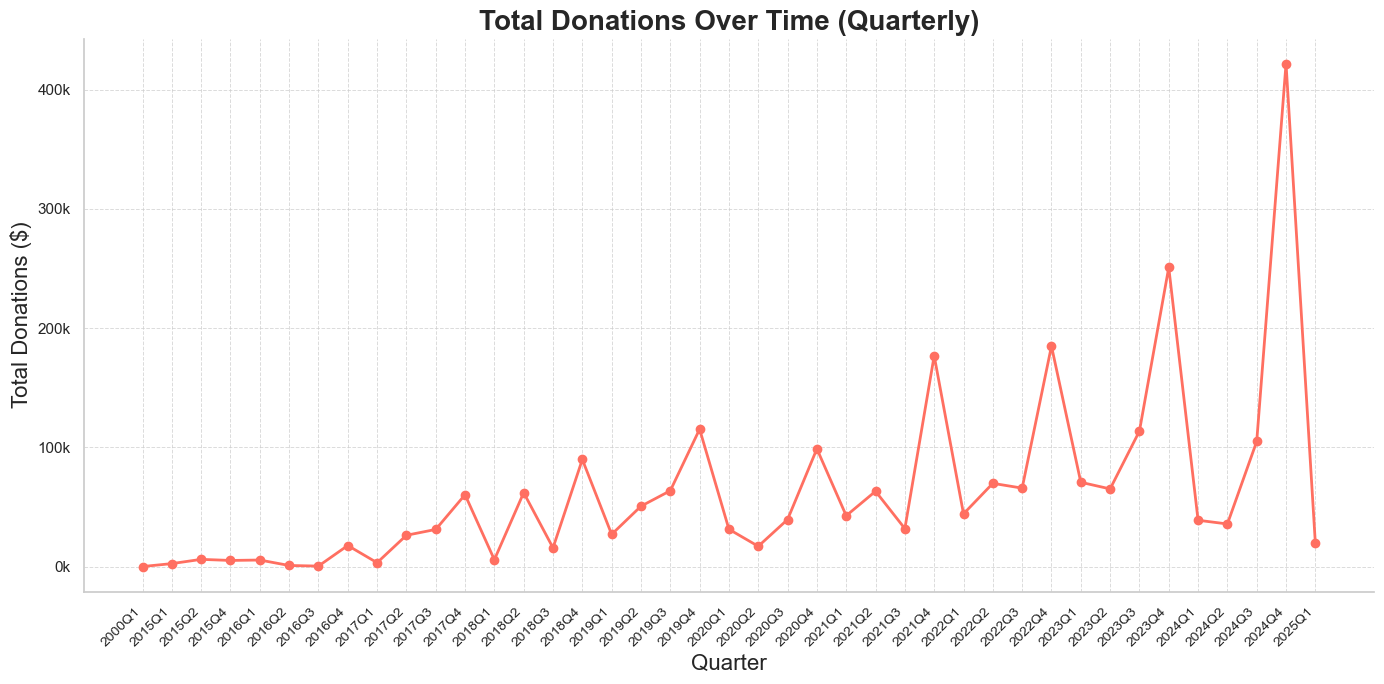

In [98]:
# 1. Group donations quarterly
data['Quarter'] = data['Date'].dt.to_period('Q')
quarterly_donations = data.groupby('Quarter')['Revenue Amount'].sum().reset_index()

# 2. Plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(quarterly_donations['Quarter'].astype(str), 
        quarterly_donations['Revenue Amount'], 
        marker='o', 
        linestyle='-', 
        color='#FF6F61', 
        linewidth=2)

ax.set_title('Total Donations Over Time (Quarterly)', fontsize=20, fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))
plt.xticks(rotation=45, ha='right', fontsize=10)

ax.grid(visible=True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


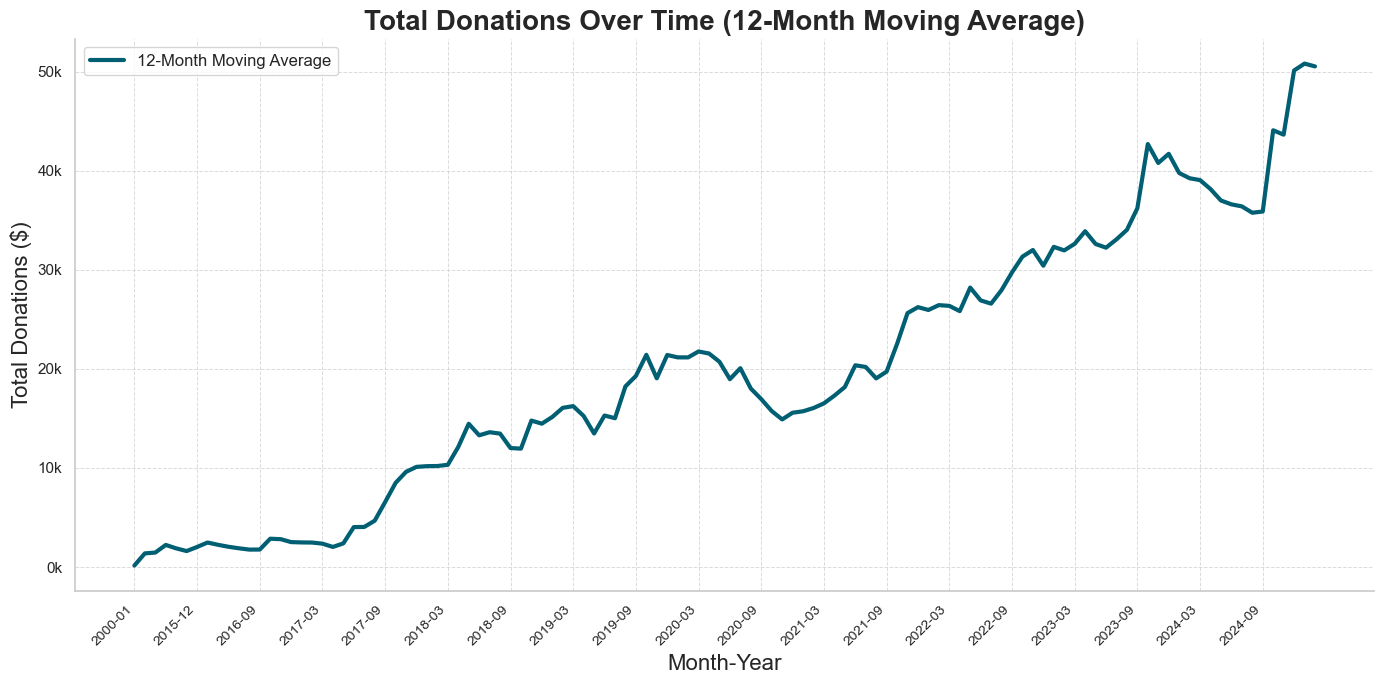

In [106]:
# 1. 12-Month Moving Average
monthly_donations = data.groupby('YearMonth')['Revenue Amount'].sum().reset_index()
monthly_donations['12_Month_MA'] = monthly_donations['Revenue Amount'].rolling(window=12, min_periods=1).mean()

# 2. Plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['12_Month_MA'], 
        color='#005f73', 
        linewidth=3, 
        linestyle='-', 
        label='12-Month Moving Average')

ax.set_title('Total Donations Over Time (12-Month Moving Average)', fontsize=20, fontweight='bold')
ax.set_xlabel('Month-Year', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))
plt.xticks(ticks=range(0, len(monthly_donations), 6), 
           labels=monthly_donations['YearMonth'].astype(str)[::6], 
           rotation=45, ha='right', fontsize=10)

ax.grid(visible=True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

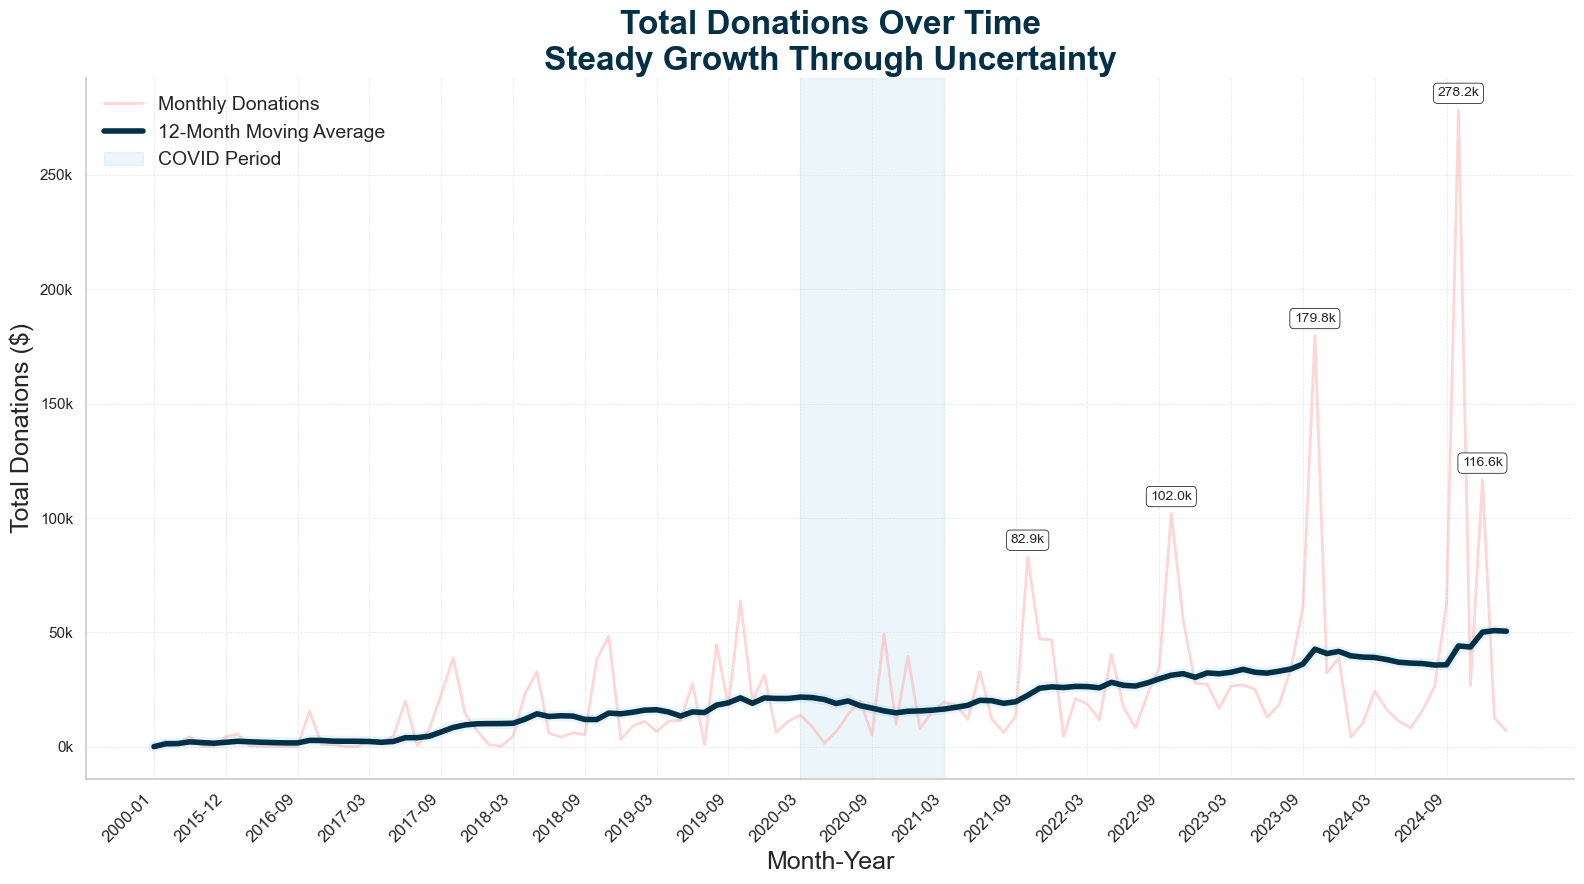

In [108]:
# 1. Group and Calculate Moving Average
monthly_donations = data.groupby('YearMonth')['Revenue Amount'].sum().reset_index()
monthly_donations['12_Month_MA'] = monthly_donations['Revenue Amount'].rolling(window=12, min_periods=1).mean()

# 2. Plot
fig, ax = plt.subplots(figsize=(16, 9))

# Faded Monthly Donations (new soft color)
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['Revenue Amount'], 
        color='#FFADAD',   # Soft Coral Pink
        alpha=0.5, 
        linewidth=2, 
        linestyle='-', 
        label='Monthly Donations')

# Strong Moving Average Line (dark bold color)
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['12_Month_MA'], 
        color='#023047',   # Dark Blue
        linewidth=4, 
        linestyle='-', 
        label='12-Month Moving Average', 
        zorder=3)

# Shadow/Glow effect under Moving Average
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['12_Month_MA'], 
        color='#8ecae6',  # Light Glow Blue
        linewidth=8, 
        alpha=0.2, 
        zorder=2)

# Title and Subtitle
ax.set_title('Total Donations Over Time\nSteady Growth Through Uncertainty', fontsize=24, fontweight='bold', color='#023047', loc='center')
ax.set_xlabel('Month-Year', fontsize=18)
ax.set_ylabel('Total Donations ($)', fontsize=18)

# Y-axis formatter
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# X-axis formatting
plt.xticks(ticks=range(0, len(monthly_donations), 6), 
           labels=monthly_donations['YearMonth'].astype(str)[::6], 
           rotation=45, ha='right', fontsize=12)

# Highlight COVID Period (more beautiful light blue)
ax.axvspan('2020-03', '2021-03', color='#d0e8f2', alpha=0.4, label='COVID Period')

# Annotate Key Donation Peaks
top_peaks = monthly_donations.nlargest(5, 'Revenue Amount')
for i, row in top_peaks.iterrows():
    ax.annotate(f'{row["Revenue Amount"]/1000:.1f}k', 
                (i, row['Revenue Amount']), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

# Light Grid
ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.5)

# Remove Top/Right Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend
ax.legend(fontsize=14, loc='upper left', frameon=False)

# Layout
plt.tight_layout()

# Show
plt.show()


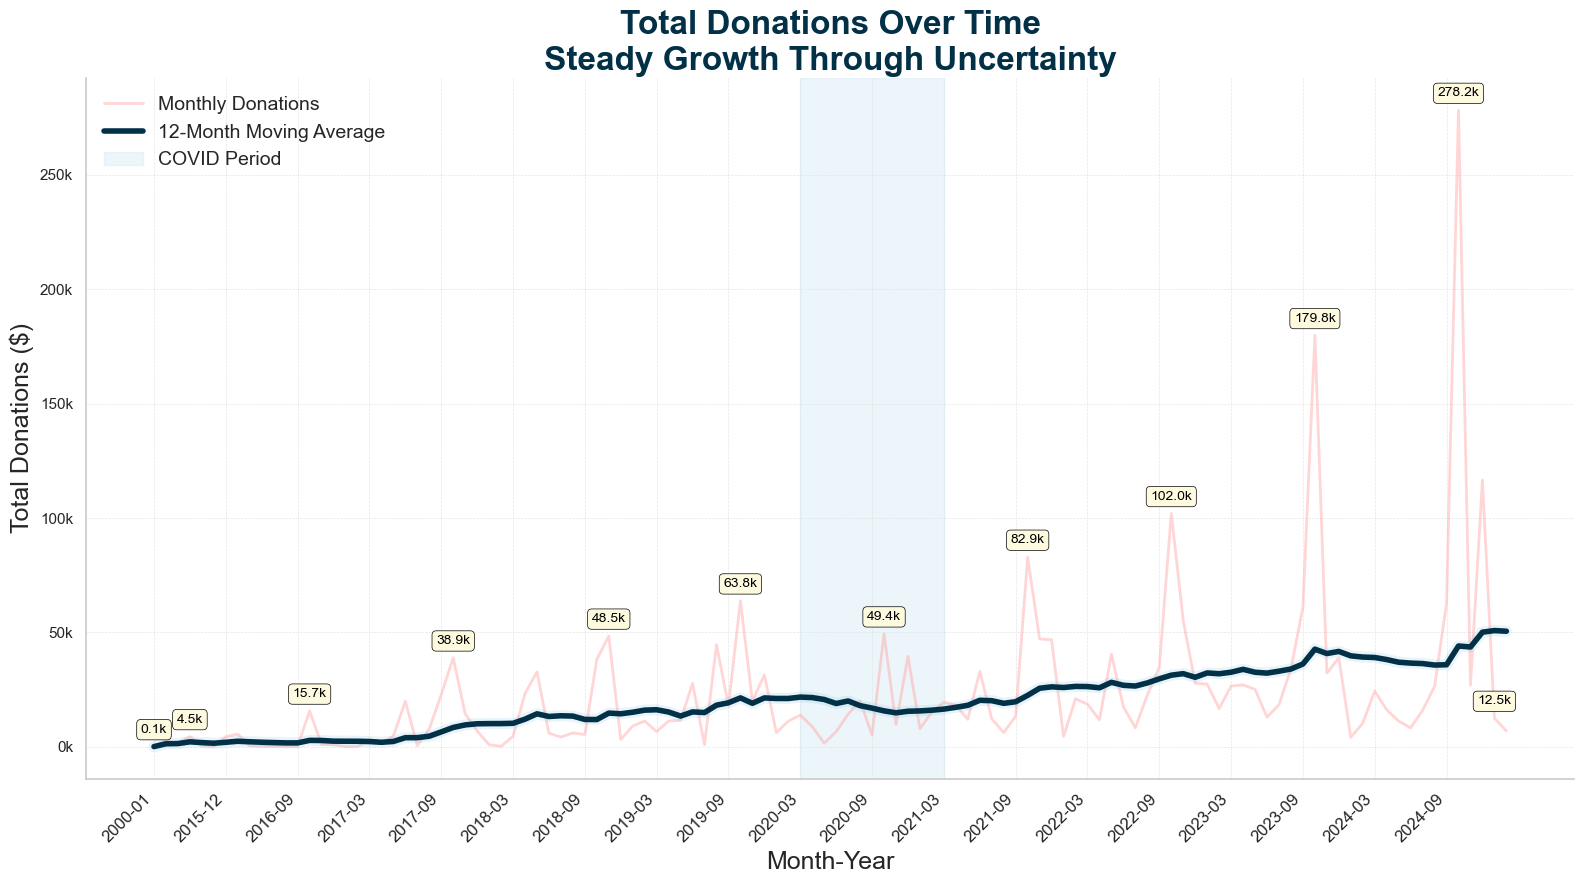

In [110]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 1. Group and Calculate Moving Average
monthly_donations = data.groupby('YearMonth')['Revenue Amount'].sum().reset_index()
monthly_donations['12_Month_MA'] = monthly_donations['Revenue Amount'].rolling(window=12, min_periods=1).mean()

# 2. Create Plot
fig, ax = plt.subplots(figsize=(16, 9))

# Faded Monthly Donations Line
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['Revenue Amount'], 
        color='#FFADAD',   # Soft Coral Pink
        alpha=0.5, 
        linewidth=2, 
        linestyle='-', 
        label='Monthly Donations')

# Strong Moving Average Line
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['12_Month_MA'], 
        color='#023047',   # Dark Blue
        linewidth=4, 
        linestyle='-', 
        label='12-Month Moving Average', 
        zorder=3)

# Soft Shadow/Glow Effect Under Moving Average
ax.plot(monthly_donations['YearMonth'].astype(str), 
        monthly_donations['12_Month_MA'], 
        color='#8ecae6',   # Light Blue Glow
        linewidth=8, 
        alpha=0.2, 
        zorder=2)

# Title and Labels
ax.set_title('Total Donations Over Time\nSteady Growth Through Uncertainty', fontsize=24, fontweight='bold', color='#023047', loc='center')
ax.set_xlabel('Month-Year', fontsize=18)
ax.set_ylabel('Total Donations ($)', fontsize=18)

# Format Y-axis in Thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# X-axis formatting
plt.xticks(ticks=range(0, len(monthly_donations), 6), 
           labels=monthly_donations['YearMonth'].astype(str)[::6], 
           rotation=45, ha='right', fontsize=12)

# Highlight COVID Period (Soft Blue)
ax.axvspan('2020-03', '2021-03', color='#d0e8f2', alpha=0.4, label='COVID Period')

# Light Grid
ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.5)

# Remove Top/Right Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 3. Annotate Peaks - One Peak Per Year
# Extract Year from YearMonth
monthly_donations['Year'] = monthly_donations['YearMonth'].dt.year

# Find the highest donation month of each year
peaks_per_year = monthly_donations.loc[monthly_donations.groupby('Year')['Revenue Amount'].idxmax()]

# Annotate peaks
for i, row in peaks_per_year.iterrows():
    ax.annotate(f'{row["Revenue Amount"]/1000:.1f}k', 
                (i, row['Revenue Amount']), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', 
                fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", fc="#fefae0", ec="black", lw=0.5),
                color='black')

# 4. Add Legend
ax.legend(fontsize=14, loc='upper left', frameon=False)

# 5. Layout and Show
plt.tight_layout()
plt.show()


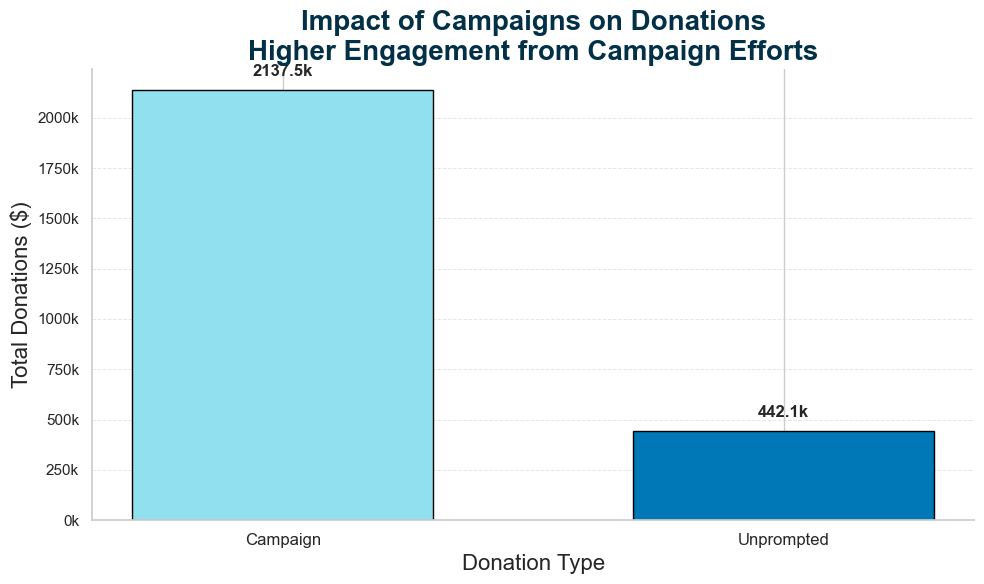

In [114]:
# --- 5.3 Campaign vs Unprompted Donations ---

# Create a clean column identifying Campaign vs Unprompted
data['Campaign_Status'] = data['Campaign'].apply(lambda x: 'Campaign' if pd.notnull(x) and x != '' else 'Unprompted')

# Group and sum
campaign_summary = data.groupby('Campaign_Status')['Revenue Amount'].sum().reset_index()

# Sort for better bar order
campaign_summary = campaign_summary.sort_values('Revenue Amount', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(campaign_summary['Campaign_Status'], 
              campaign_summary['Revenue Amount'], 
              color=['#90e0ef', '#0077b6'],  # Light Blue and Dark Blue
              edgecolor='black', 
              width=0.6)

# Titles and Labels
ax.set_title('Impact of Campaigns on Donations\nHigher Engagement from Campaign Efforts', 
             fontsize=20, fontweight='bold', color='#023047', loc='center')
ax.set_xlabel('Donation Type', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

# Format Y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Add gridlines
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.5)

# Remove Top/Right Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate bars with exact donation values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height/1000:.1f}k', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 8),  # 8 points above bar
                textcoords="offset points",
                ha='center', va='bottom', 
                fontsize=12, fontweight='bold')

# X-ticks
plt.xticks(fontsize=12)

# Tight layout
plt.tight_layout()

# Show plot
plt.show()


/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/896218683.py:60: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


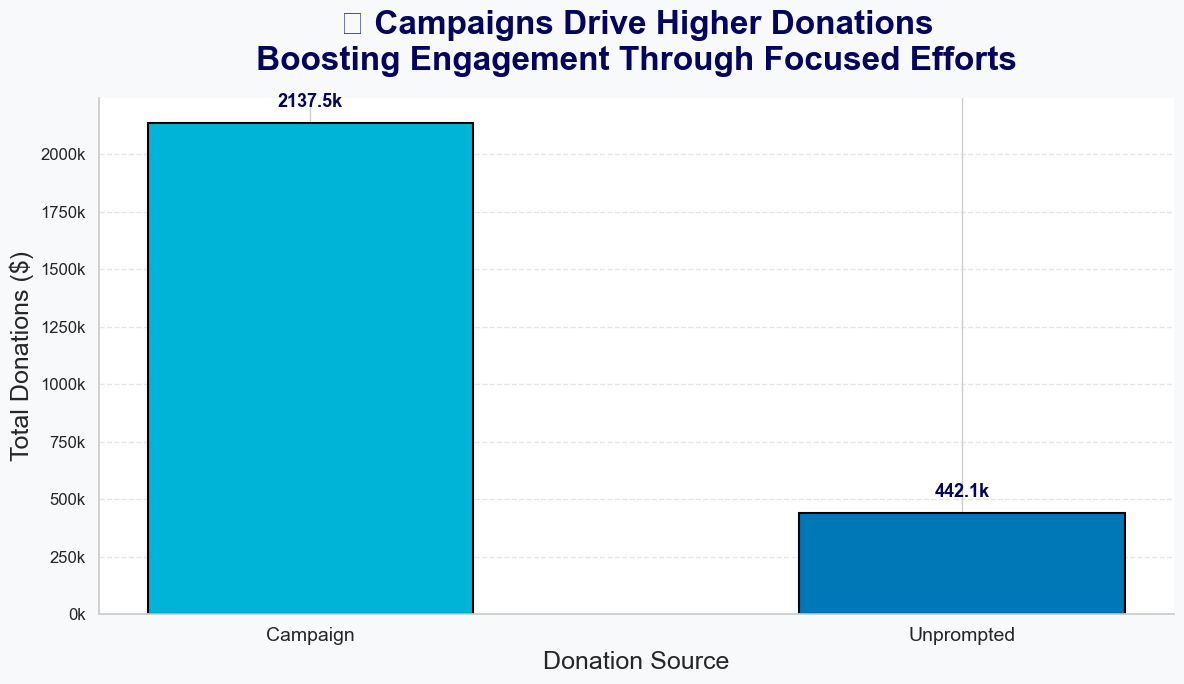

In [116]:
# --- 5.3 Campaign vs Unprompted Donations ---

# Create clean label
data['Campaign_Status'] = data['Campaign'].apply(lambda x: 'Campaign' if pd.notnull(x) and x != '' else 'Unprompted')

# Group
campaign_summary = data.groupby('Campaign_Status')['Revenue Amount'].sum().reset_index()
campaign_summary = campaign_summary.sort_values('Revenue Amount', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

# Set colors
colors = ['#00b4d8', '#0077b6']  # Teal blue + Navy

# Create bars
bars = ax.bar(campaign_summary['Campaign_Status'], 
              campaign_summary['Revenue Amount'], 
              color=colors, 
              edgecolor='black', 
              linewidth=1.5, 
              width=0.5)

# Titles and Labels
ax.set_title('🌟 Campaigns Drive Higher Donations\nBoosting Engagement Through Focused Efforts', 
             fontsize=24, fontweight='bold', color='#03045e', loc='center', pad=20)
ax.set_xlabel('Donation Source', fontsize=18)
ax.set_ylabel('Total Donations ($)', fontsize=18)

# Format Y-axis nicely
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Gridlines - soft
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate exact donation values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height/1000:.1f}k', 
                xy=(bar.get_x() + bar.get_width()/2, height), 
                xytext=(0, 8), 
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=13, fontweight='bold', color='#03045e')

# Style X-ticks
plt.xticks(fontsize=14)

# Style Y-ticks
plt.yticks(fontsize=12)

# Add slight background shade
fig.patch.set_facecolor('#f7f9fb')  # Very light gray background

# Tight Layout
plt.tight_layout()

# Show plot
plt.show()


/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/4275152475.py:53: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


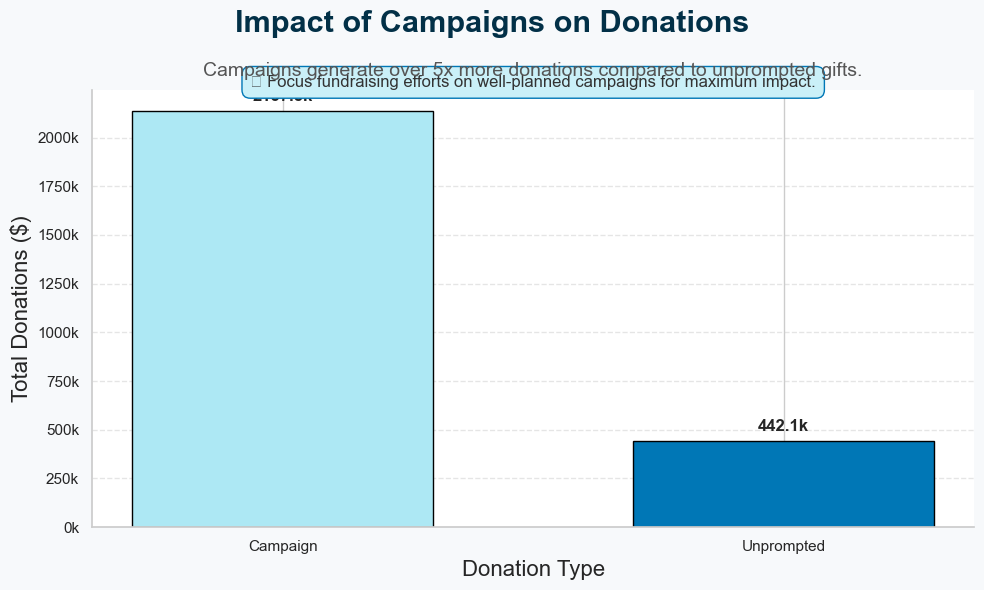

In [136]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Group data
campaign_summary = data.groupby('Campaign_Status')['Revenue Amount'].sum()

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Bar colors
colors = ['#ade8f4', '#0077b6']

# Plot
bars = ax.bar(campaign_summary.index, 
              campaign_summary.values, 
              color=colors, 
              edgecolor='black', 
              width=0.6)

# Title and Subtitle
plt.suptitle('Impact of Campaigns on Donations', fontsize=22, fontweight='bold', color='#023047')
plt.title('Campaigns generate over 5x more donations compared to unprompted gifts.', fontsize=14, color='#555', pad=10)

# Labels
ax.set_xlabel('Donation Type', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

# Y-axis in thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Direct labels on bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height/1000:.1f}k', 
                xy=(bar.get_x() + bar.get_width()/2, height), 
                xytext=(0,5), 
                textcoords='offset points',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add a light textbox takeaway
plt.text(0.5, max(campaign_summary)*1.05, 
         '🔍 Focus fundraising efforts on well-planned campaigns for maximum impact.', 
         fontsize=12, color='#333', ha='center', va='bottom', 
         bbox=dict(facecolor='#caf0f8', edgecolor='#0077b6', boxstyle='round,pad=0.5'))

# Style tweaks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.5)

fig.patch.set_facecolor('#f7f9fb')

plt.tight_layout()
plt.show()


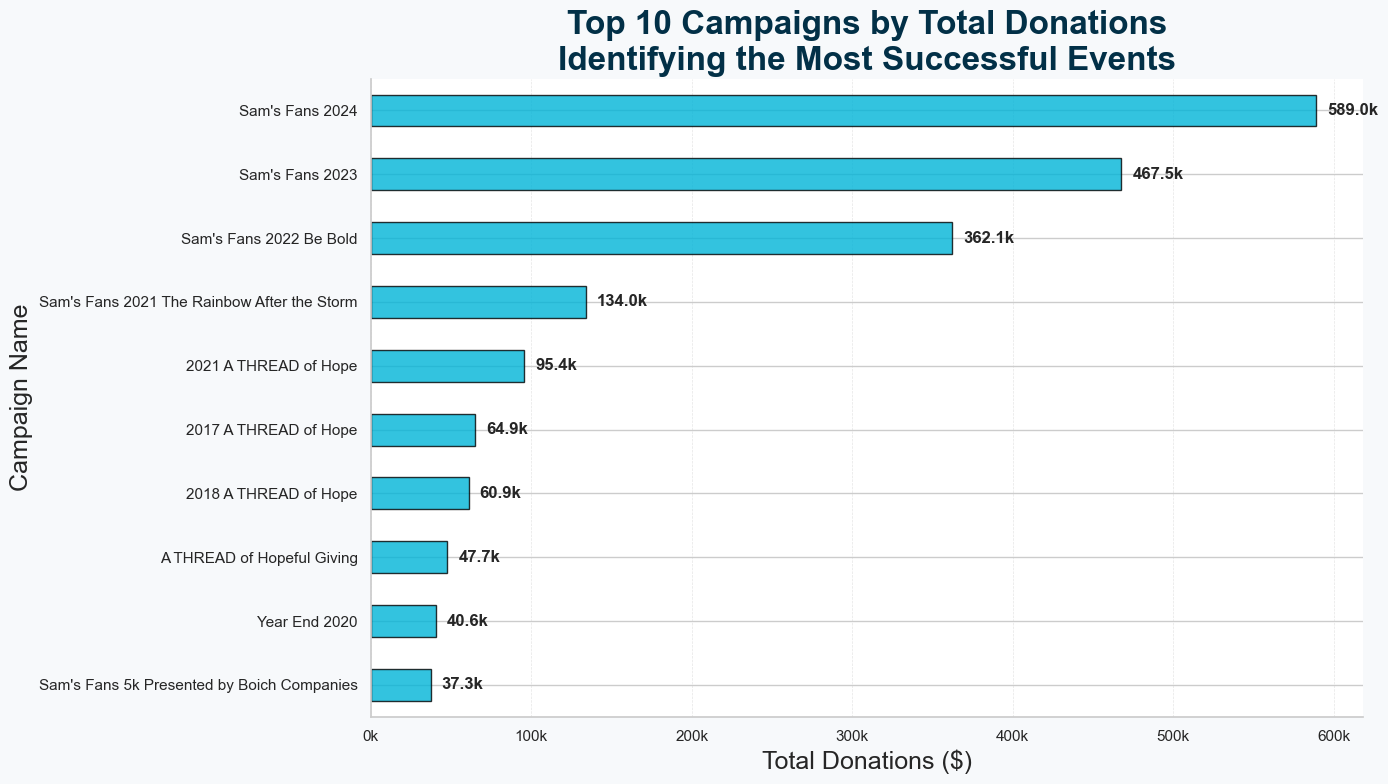

In [122]:
# Group and sort top campaigns
top_campaigns = data.groupby('Campaign')['Revenue Amount'].sum().sort_values(ascending=False).head(10)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

top_campaigns.plot(kind='barh', 
                   color='#00b4d8',  # Vibrant blue
                   edgecolor='black', 
                   alpha=0.8)

# Title and labels
ax.set_title('Top 10 Campaigns by Total Donations\nIdentifying the Most Successful Events', 
             fontsize=24, fontweight='bold', color='#023047')
ax.set_xlabel('Total Donations ($)', fontsize=18)
ax.set_ylabel('Campaign Name', fontsize=18)
ax.invert_yaxis()  # Highest campaign at the top

# Format X-axis in Thousands
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Annotate bar values
for i in ax.patches:
    ax.annotate(f'{i.get_width()/1000:.1f}k', 
                (i.get_width(), i.get_y() + i.get_height()/2),
                xytext=(8,0), textcoords='offset points', 
                ha='left', va='center', fontsize=12, fontweight='bold')

# Grid
ax.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.5)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Background
fig.patch.set_facecolor('#f7f9fb')  # Light soft background

plt.tight_layout()
plt.show()


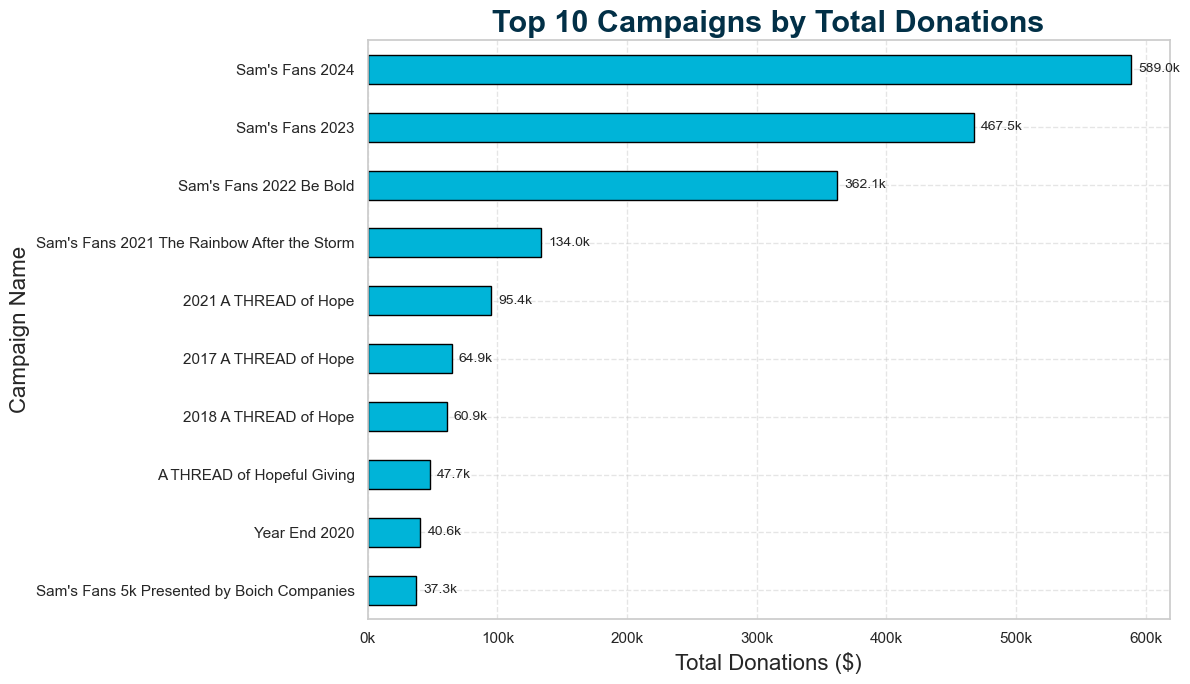

In [118]:
# Find top campaigns by total donations
top_campaigns = data.groupby('Campaign')['Revenue Amount'].sum().sort_values(ascending=False).head(10)

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

top_campaigns.plot(kind='barh', color='#00b4d8', edgecolor='black', ax=ax)

ax.set_title('Top 10 Campaigns by Total Donations', fontsize=22, fontweight='bold', color='#023047')
ax.set_xlabel('Total Donations ($)', fontsize=16)
ax.set_ylabel('Campaign Name', fontsize=16)
ax.invert_yaxis()  # Highest at top

# Format Y-axis in thousands
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Add donation values on bars
for i in ax.patches:
    ax.annotate(f'{i.get_width()/1000:.1f}k', 
                (i.get_width(), i.get_y() + i.get_height()/2),
                xytext=(5,0), textcoords='offset points', 
                ha='left', va='center', fontsize=10)

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


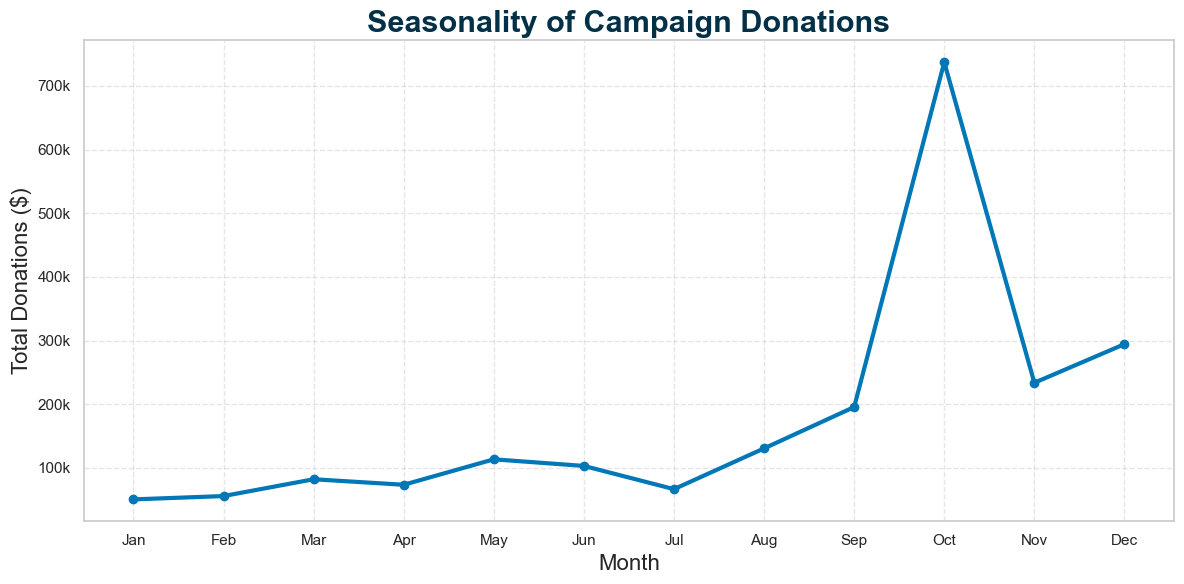

In [120]:
# Add 'Month' if not already added
data['Month'] = data['Date'].dt.month

# Focus on only Campaign donations
campaign_only = data[data['Campaign_Status'] == 'Campaign']

# Group by Month
monthly_campaigns = campaign_only.groupby('Month')['Revenue Amount'].sum()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

monthly_campaigns.plot(kind='line', marker='o', color='#0077b6', linewidth=3)

ax.set_title('Seasonality of Campaign Donations', fontsize=22, fontweight='bold', color='#023047')
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Y-axis formatting
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


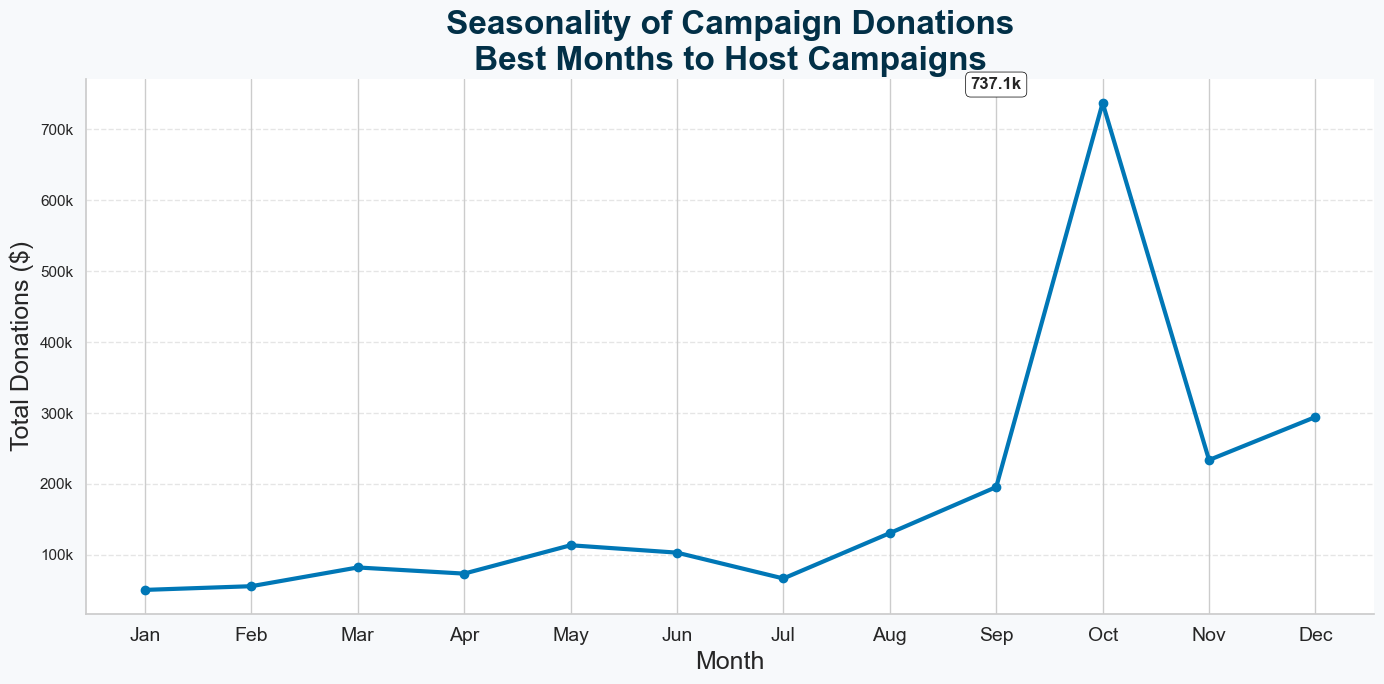

In [124]:
# Group monthly campaigns
campaign_only = data[data['Campaign_Status'] == 'Campaign']
monthly_campaigns = campaign_only.groupby('Month')['Revenue Amount'].sum()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

monthly_campaigns.plot(kind='line', 
                       marker='o', 
                       color='#0077b6', 
                       linewidth=3)

# Title and labels
ax.set_title('Seasonality of Campaign Donations\nBest Months to Host Campaigns', 
             fontsize=24, fontweight='bold', color='#023047')
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Total Donations ($)', fontsize=18)
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)

# Format Y-axis in Thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Annotate peaks (highest month)
peak_month = monthly_campaigns.idxmax()
peak_value = monthly_campaigns.max()

ax.annotate(f'{peak_value/1000:.1f}k', 
            xy=(peak_month-1, peak_value), 
            xytext=(0,10), 
            textcoords='offset points',
            ha='center', fontsize=12, fontweight='bold', 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

# Light grid
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Background
fig.patch.set_facecolor('#f7f9fb')  # Light background

plt.tight_layout()
plt.show()


/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/605994860.py:37: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/605994860.py:37: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


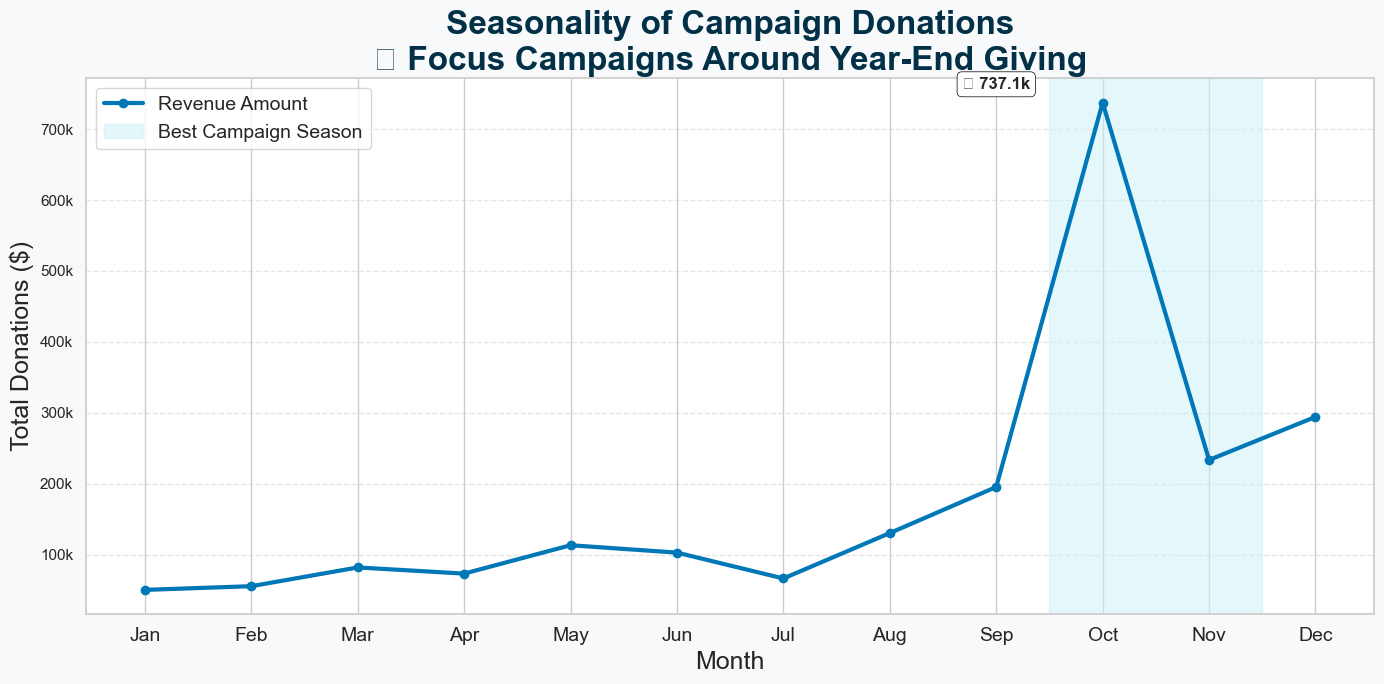

In [128]:
# Seasonality of Campaign Donations
campaign_only = data[data['Campaign_Status'] == 'Campaign']
monthly_campaigns = campaign_only.groupby('Month')['Revenue Amount'].sum()

fig, ax = plt.subplots(figsize=(14, 7))

monthly_campaigns.plot(kind='line', marker='o', color='#0077b6', linewidth=3)

ax.set_title('Seasonality of Campaign Donations\n🎯 Focus Campaigns Around Year-End Giving', 
             fontsize=24, fontweight='bold', color='#023047')
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Total Donations ($)', fontsize=18)
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Highlight October to December
ax.axvspan(9.5, 11.5, color='#caf0f8', alpha=0.5, label='Best Campaign Season')

# Annotate peak
peak_month = monthly_campaigns.idxmax()
peak_value = monthly_campaigns.max()

ax.annotate(f'🏆 {peak_value/1000:.1f}k', 
            xy=(peak_month-1, peak_value), 
            xytext=(0,10), 
            textcoords='offset points',
            ha='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(fontsize=14)

fig.patch.set_facecolor('#f7f9fb')
plt.tight_layout()
plt.show()


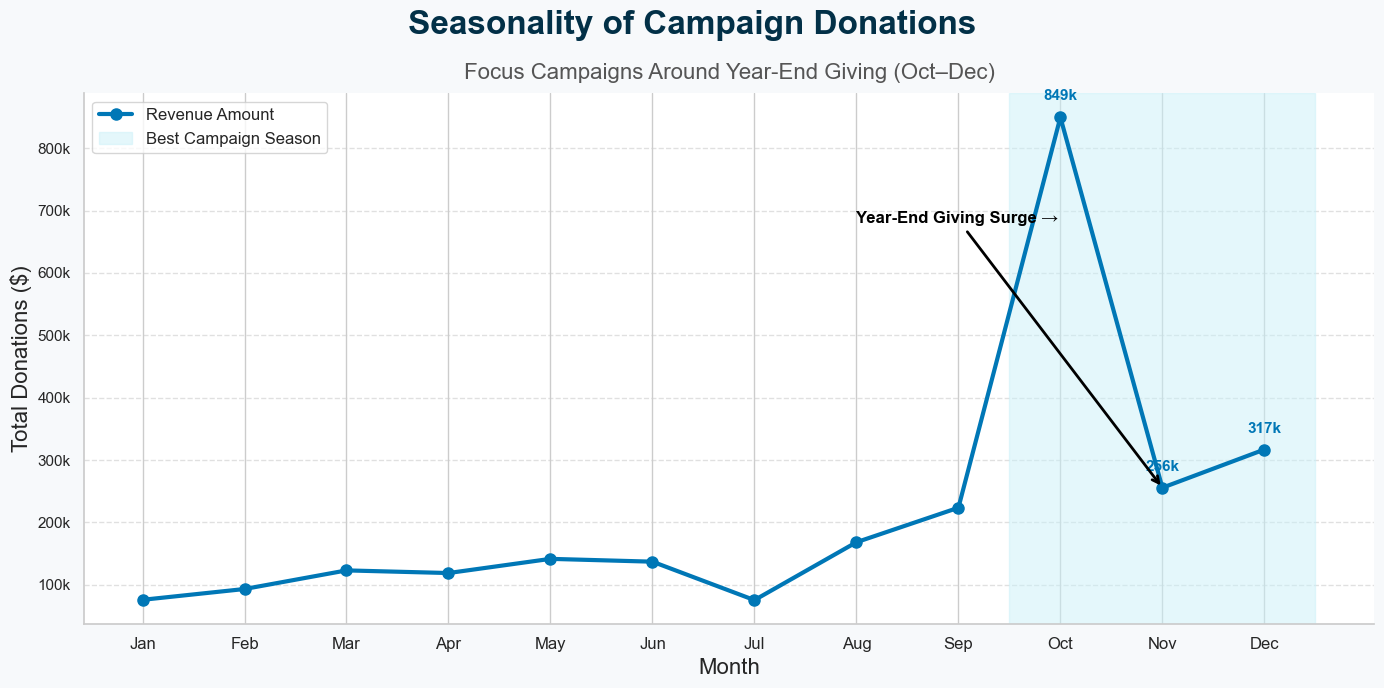

In [138]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Group by month
monthly_campaigns = data.groupby(data['Date'].dt.month)['Revenue Amount'].sum()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

# Line plot with markers
ax.plot(monthly_campaigns.index, 
        monthly_campaigns.values, 
        color='#0077b6', 
        linewidth=3, 
        marker='o', 
        markersize=8, 
        label='Revenue Amount')

# Highlight best season (Oct-Nov-Dec)
ax.axvspan(10-0.5, 12+0.5, color='#caf0f8', alpha=0.5, label='Best Campaign Season')

# Titles
plt.suptitle('Seasonality of Campaign Donations', fontsize=24, fontweight='bold', color='#023047')
plt.title('Focus Campaigns Around Year-End Giving (Oct–Dec)', fontsize=16, color='#555', pad=10)

# X and Y labels
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Total Donations ($)', fontsize=16)

# X-axis ticks
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=np.arange(1,13), labels=months, fontsize=12)

# Y-axis format
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k'))

# Annotate top 3 months
top_months = monthly_campaigns.sort_values(ascending=False).head(3)
for month, value in top_months.items():
    ax.annotate(f'{value/1000:.0f}k', 
                xy=(month, value), 
                xytext=(0, 10), 
                textcoords='offset points',
                ha='center', va='bottom', 
                fontsize=11, fontweight='bold', 
                color='#0077b6')

# Add text annotation
ax.annotate('Year-End Giving Surge →', 
            xy=(11, monthly_campaigns[11]), 
            xytext=(8, monthly_campaigns.max()*0.8),
            arrowprops=dict(arrowstyle="->", color='black', lw=2),
            fontsize=12, fontweight='bold', color='black')

# Style tweaks
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.patch.set_facecolor('#f7f9fb')

plt.tight_layout()
plt.show()


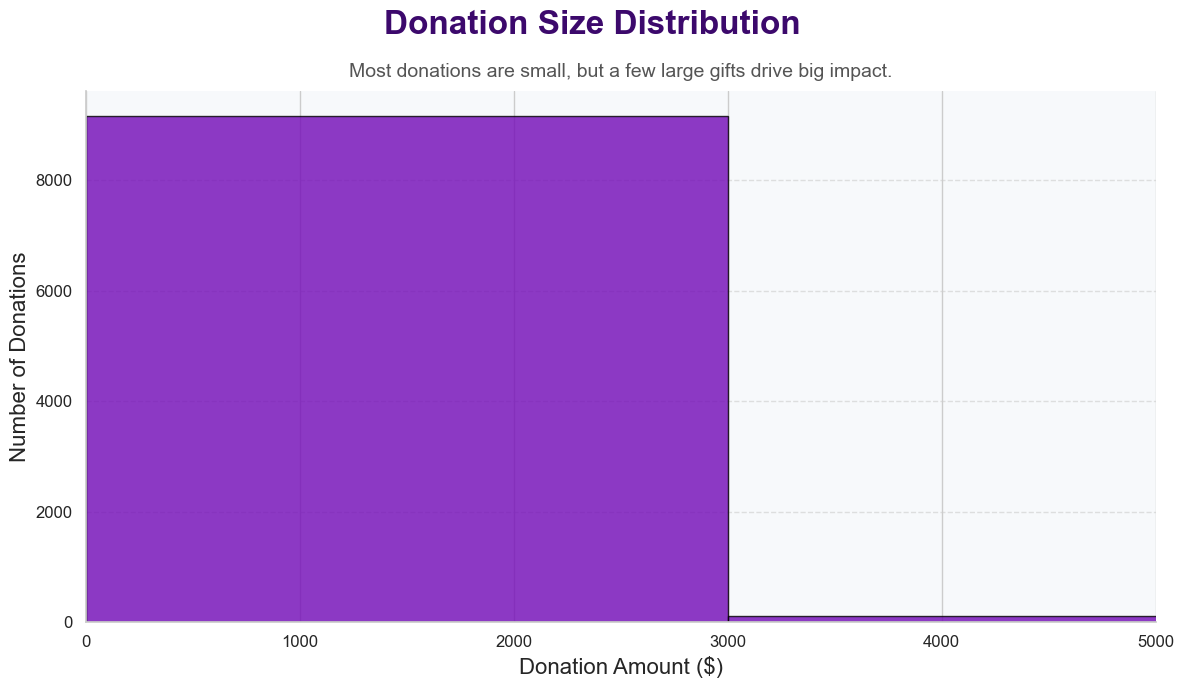

In [142]:
import matplotlib.pyplot as plt

# --- 5.4 Donation Size Distribution ---

plt.figure(figsize=(12, 7))

# Use correct column
plt.hist(data['Revenue Amount'], 
         bins=30, 
         color='#7209b7', 
         edgecolor='black', 
         alpha=0.8)

# Titles and labels
plt.suptitle('Donation Size Distribution', fontsize=24, fontweight='bold', color='#3c096c')
plt.title('Most donations are small, but a few large gifts drive big impact.', fontsize=14, color='#555', pad=10)
plt.xlabel('Donation Amount ($)', fontsize=16)
plt.ylabel('Number of Donations', fontsize=16)

# X limit
plt.xlim(0, 5000)  # You can adjust if your data has larger donations

# Light grid
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Style tweaks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().patch.set_facecolor('#f7f9fb')

plt.tight_layout()
plt.show()


<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/742958013.py:34: SyntaxWarning: invalid escape sequence '\$'
  ['\$10', '\$30', '\$100', '\$300', '\$1k', '\$3k', '\$5k'], fontsize=12)
/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/742958013.py:34: Syn

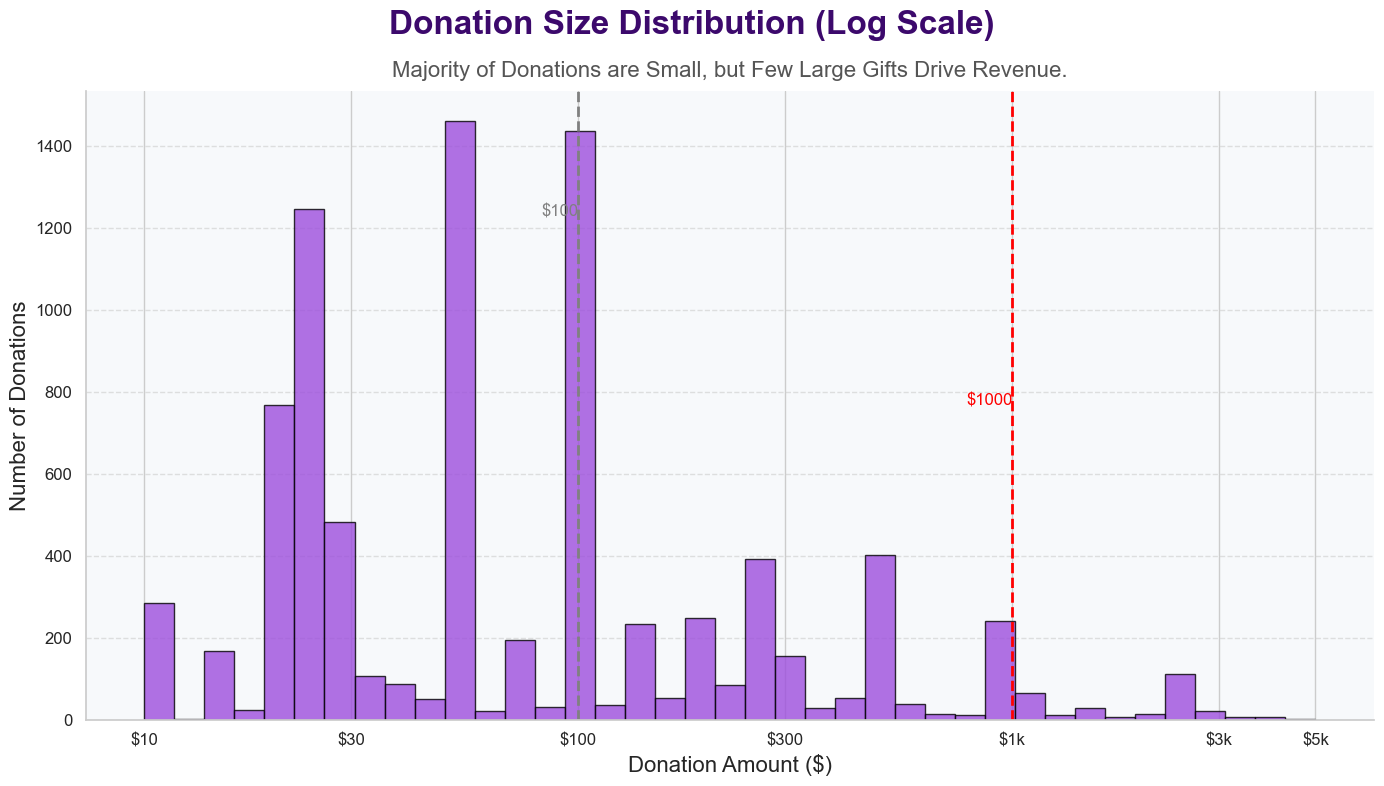

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# --- Better Donation Size Distribution Plot ---
plt.figure(figsize=(14, 8))

# Plot Histogram
plt.hist(data['Revenue Amount'], 
         bins=np.logspace(np.log10(10), np.log10(5000), 40), 
         color='#9d4edd', 
         edgecolor='black', 
         alpha=0.8)

# Set log scale
plt.xscale('log')

# Titles
plt.suptitle('Donation Size Distribution (Log Scale)', fontsize=24, fontweight='bold', color='#3c096c')
plt.title('Majority of Donations are Small, but Few Large Gifts Drive Revenue.', fontsize=16, color='#555', pad=10)

# Labels
plt.xlabel('Donation Amount ($)', fontsize=16)
plt.ylabel('Number of Donations', fontsize=16)

# Vertical lines to show thresholds
plt.axvline(100, color='grey', linestyle='--', lw=2)
plt.text(100, plt.ylim()[1]*0.8, '$100', color='grey', fontsize=12, ha='right')

plt.axvline(1000, color='red', linestyle='--', lw=2)
plt.text(1000, plt.ylim()[1]*0.5, '$1000', color='red', fontsize=12, ha='right')

# X-ticks formatted for log scale
plt.xticks([10, 30, 100, 300, 1000, 3000, 5000], 
           ['\$10', '\$30', '\$100', '\$300', '\$1k', '\$3k', '\$5k'], fontsize=12)
plt.yticks(fontsize=12)

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Style tweaks
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().patch.set_facecolor('#f7f9fb')

plt.tight_layout()
plt.show()


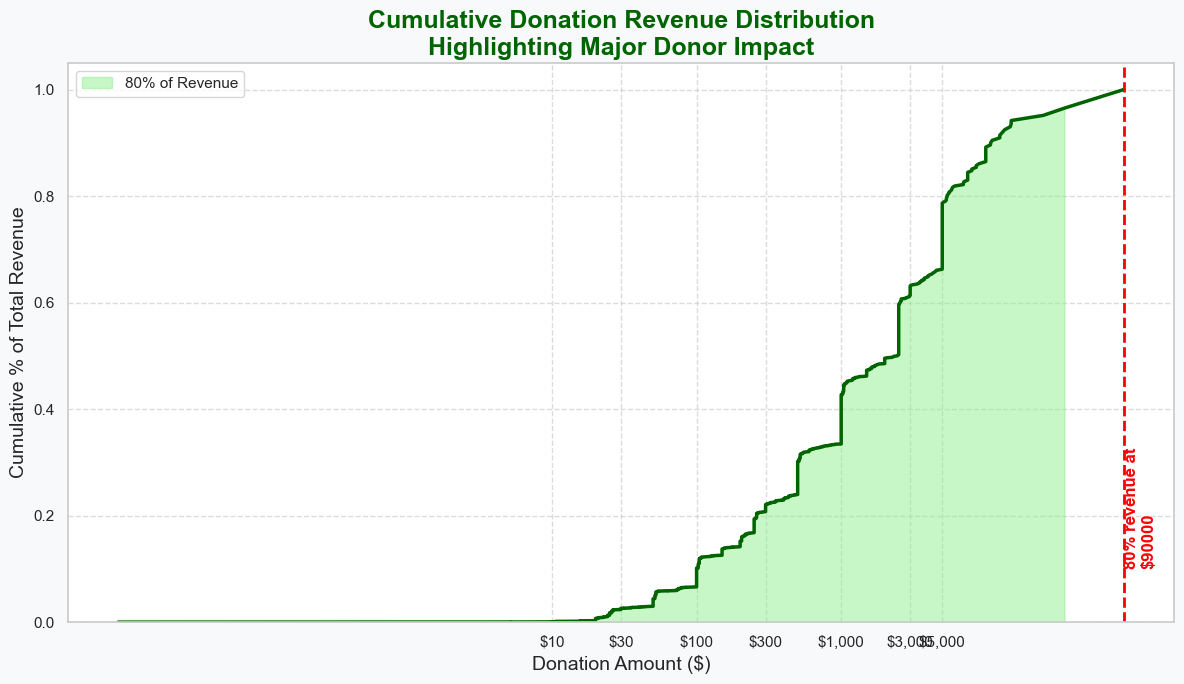

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Sort donations
donations = data['Revenue Amount'].sort_values(ascending=True).reset_index(drop=True)

# 🛡️ Filter only positive donations
donations = donations[donations > 0]

# 2. Calculate cumulative revenue
cumulative_revenue = donations.cumsum()
total_revenue = cumulative_revenue.iloc[-1]
cumulative_percentage = cumulative_revenue / total_revenue

# 3. Check carefully for 80% threshold
try:
    threshold_idx = cumulative_percentage[cumulative_percentage >= 0.8].index[0]
    threshold_value = donations.iloc[threshold_idx]
except IndexError:
    # If 80% is never reached
    threshold_idx = len(donations) - 1
    threshold_value = donations.iloc[-1]

# 4. Plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot cumulative revenue
ax.plot(donations, cumulative_percentage, color='darkgreen', linewidth=2.5)

# Fill under 80% of revenue
ax.fill_between(donations[:threshold_idx], cumulative_percentage[:threshold_idx], 
                color='lightgreen', alpha=0.5, label='80% of Revenue')

# Mark threshold
ax.axvline(x=threshold_value, color='red', linestyle='--', linewidth=2)
ax.text(threshold_value, 0.1, f'80% revenue at\n${threshold_value:.0f}', 
        color='red', fontsize=12, rotation=90, verticalalignment='bottom', fontweight='bold')

# Title and labels
ax.set_title('Cumulative Donation Revenue Distribution\nHighlighting Major Donor Impact', 
             fontsize=18, fontweight='bold', color='darkgreen')
ax.set_xlabel('Donation Amount ($)', fontsize=14)
ax.set_ylabel('Cumulative % of Total Revenue', fontsize=14)
ax.set_ylim(0, 1.05)

# X-axis log scale
ax.set_xscale('log')
ax.set_xticks([10, 30, 100, 300, 1000, 3000, 5000])
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x):,}'))

# Grid, legend, and layout
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
fig.patch.set_facecolor('#f7f9fb')

plt.tight_layout()
plt.show()


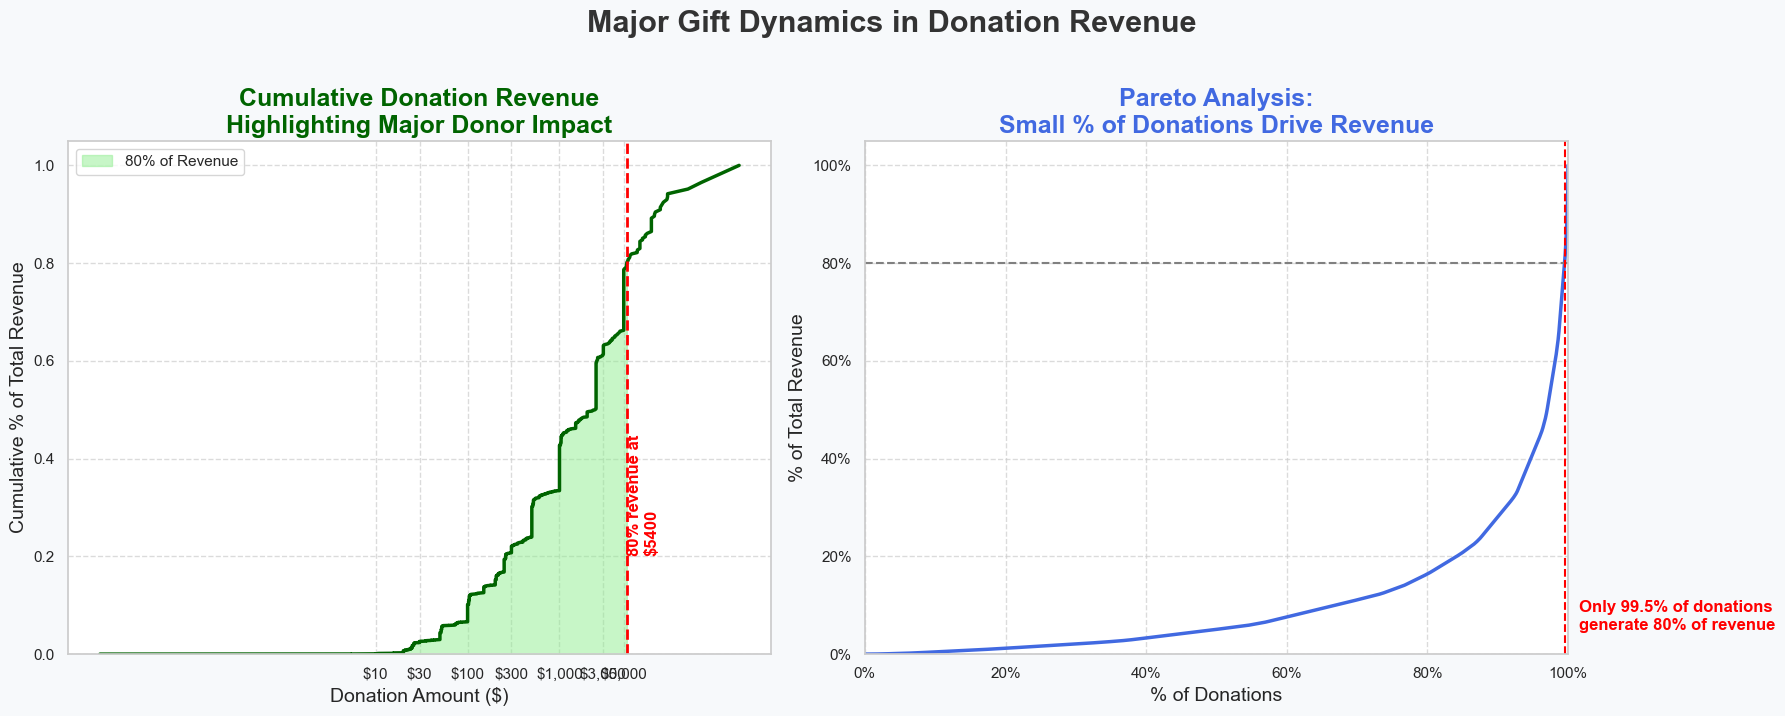

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Prepare the data
donations = data['Revenue Amount'].copy()
donations = donations[donations > 0]  # Only positive donations
donations = donations.sort_values(ascending=True).reset_index(drop=True)

cumulative_revenue = donations.cumsum()
total_revenue = cumulative_revenue.iloc[-1]
cumulative_percentage = cumulative_revenue / total_revenue

# Pareto: percentage of donations
donation_percentage = np.linspace(0, 1, len(donations))

# Find the 80% revenue threshold
threshold_idx = cumulative_percentage[cumulative_percentage >= 0.8].index[0]
threshold_value = donations.iloc[threshold_idx]
threshold_donor_percentage = donation_percentage[threshold_idx]

# 2. Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Left: Cumulative Distribution Plot ---
ax1.plot(donations, cumulative_percentage, color='darkgreen', linewidth=2.5)

# Shade under 80% revenue
ax1.fill_between(donations[:threshold_idx], cumulative_percentage[:threshold_idx], 
                 color='lightgreen', alpha=0.5, label='80% of Revenue')

# Mark the 80% threshold
ax1.axvline(x=threshold_value, color='red', linestyle='--', linewidth=2)
ax1.text(threshold_value, 0.2, f'80% revenue at\n${threshold_value:.0f}', color='red', 
         fontsize=12, rotation=90, verticalalignment='bottom', fontweight='bold')

# Style
ax1.set_title('Cumulative Donation Revenue\nHighlighting Major Donor Impact', fontsize=18, fontweight='bold', color='darkgreen')
ax1.set_xlabel('Donation Amount ($)', fontsize=14)
ax1.set_ylabel('Cumulative % of Total Revenue', fontsize=14)
ax1.set_ylim(0, 1.05)
ax1.set_xscale('log')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Format x-axis
ax1.set_xticks([10, 30, 100, 300, 1000, 3000, 5000])
ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x):,}'))

# --- Right: Pareto Chart ---
ax2.plot(donation_percentage, cumulative_percentage, color='royalblue', linewidth=2.5)
ax2.axhline(0.8, color='grey', linestyle='--')
ax2.axvline(threshold_donor_percentage, color='red', linestyle='--')

# Annotate
ax2.text(threshold_donor_percentage + 0.02, 0.05, 
         f'Only {threshold_donor_percentage*100:.1f}% of donations\ngenerate 80% of revenue', 
         color='red', fontsize=12, fontweight='bold')

# Style
ax2.set_title('Pareto Analysis:\nSmall % of Donations Drive Revenue', fontsize=18, fontweight='bold', color='royalblue')
ax2.set_xlabel('% of Donations', fontsize=14)
ax2.set_ylabel('% of Total Revenue', fontsize=14)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1.05)
ax2.grid(True, linestyle='--', alpha=0.7)

# X-axis ticks as %
ax2.set_xticks(np.linspace(0, 1, 6))
ax2.set_xticklabels([f'{int(x*100)}%' for x in np.linspace(0, 1, 6)])
ax2.set_yticks(np.linspace(0, 1, 6))
ax2.set_yticklabels([f'{int(x*100)}%' for x in np.linspace(0, 1, 6)])

# --- Layout ---
fig.patch.set_facecolor('#f7f9fb')
plt.suptitle('Major Gift Dynamics in Donation Revenue', fontsize=22, fontweight='bold', color='#333333', y=1.02)
plt.tight_layout()
plt.show()


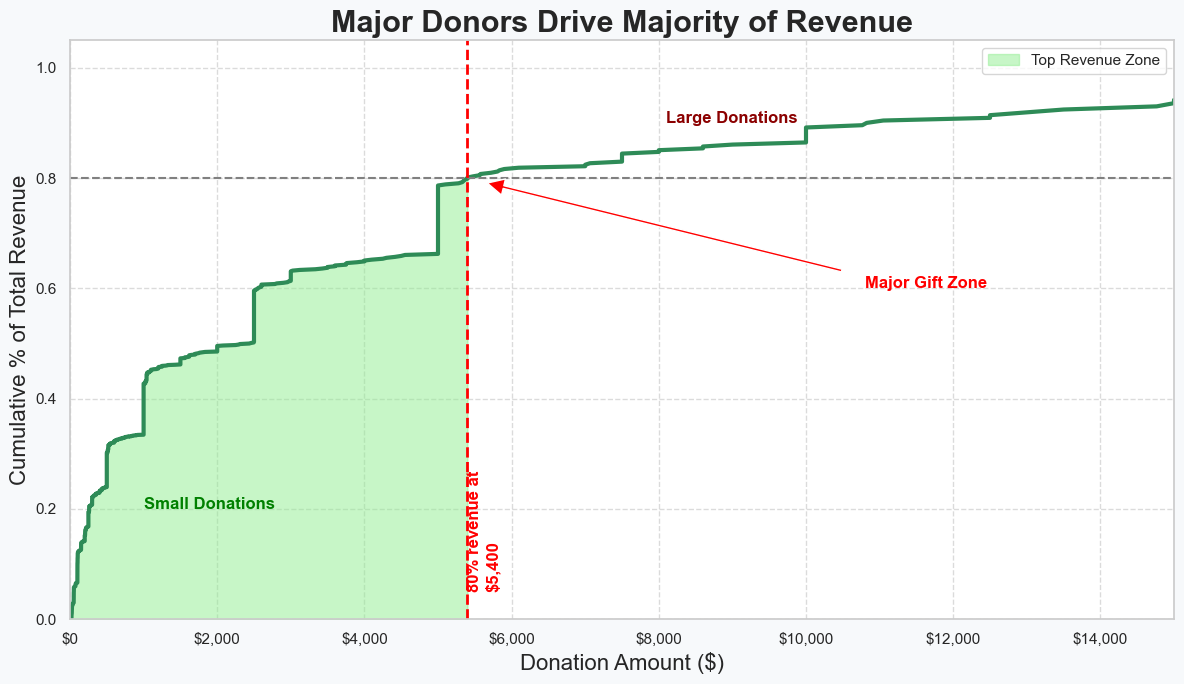

In [158]:
import matplotlib.pyplot as plt
import pandas as pd

# Sort and prepare data
donations = data['Revenue Amount']
donations = donations[donations > 0].sort_values(ascending=True).reset_index(drop=True)

# Cumulative revenue
cumulative_revenue = donations.cumsum()
total_revenue = cumulative_revenue.iloc[-1]
cumulative_percentage = cumulative_revenue / total_revenue

# Find 80% point
threshold_idx = cumulative_percentage[cumulative_percentage >= 0.8].index[0]
threshold_value = donations.iloc[threshold_idx]

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

# Main cumulative curve
ax.plot(donations, cumulative_percentage, color='seagreen', linewidth=3)

# Highlight 80% zone
ax.axhline(0.8, color='gray', linestyle='--', linewidth=1.5)
ax.axvline(threshold_value, color='red', linestyle='--', linewidth=2)

# Fill area under 80%
ax.fill_between(donations, 0, cumulative_percentage, 
                where=(cumulative_percentage <= 0.8), 
                color='lightgreen', alpha=0.5, label='Top Revenue Zone')

# Annotations
ax.text(threshold_value, 0.05, f'80% revenue at\n${int(threshold_value):,}', 
        color='red', fontsize=12, rotation=90, verticalalignment='bottom', fontweight='bold')

ax.annotate('Major Gift Zone', xy=(threshold_value, 0.8), xytext=(threshold_value*2, 0.6),
            arrowprops=dict(facecolor='red', shrink=0.05, width=2), 
            fontsize=12, color='red', fontweight='bold')

ax.text(1000, 0.2, "Small Donations", fontsize=12, color='green', fontweight='bold')
ax.text(threshold_value*1.5, 0.9, "Large Donations", fontsize=12, color='darkred', fontweight='bold')

# Titles and labels
ax.set_title('Major Donors Drive Majority of Revenue', fontsize=22, fontweight='bold')
ax.set_xlabel('Donation Amount ($)', fontsize=16)
ax.set_ylabel('Cumulative % of Total Revenue', fontsize=16)

# Limits
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 15000)  # Focus on relevant donation range

# Grid and background
ax.grid(True, linestyle='--', alpha=0.7)
fig.patch.set_facecolor('#f7f9fb')

# Format x-axis nicely
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x):,}'))

ax.legend()
plt.tight_layout()
plt.show()


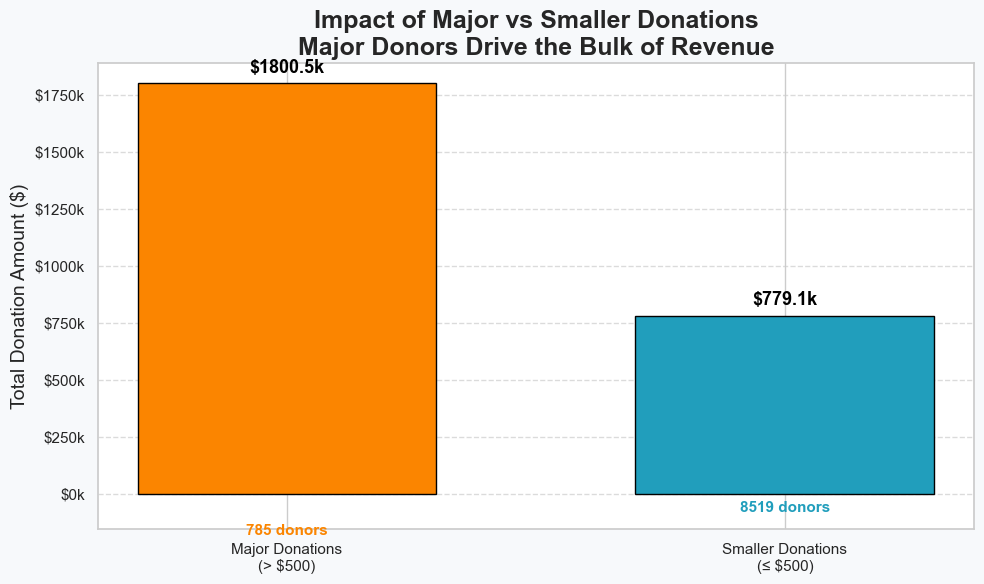

In [168]:
import matplotlib.pyplot as plt
import pandas as pd

# Set a sensible major donation threshold
threshold_value = 500  # You can change to 1000 if needed

# Group by large and small donations
large_donations = data[data['Revenue Amount'] > threshold_value]['Revenue Amount']
small_donations = data[data['Revenue Amount'] <= threshold_value]['Revenue Amount']

large_sum = large_donations.sum()
small_sum = small_donations.sum()
large_count = large_donations.count()
small_count = small_donations.count()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar([f'Major Donations\n(> ${threshold_value:,})', 
               f'Smaller Donations\n(≤ ${threshold_value:,})'], 
              [large_sum, small_sum], 
              color=['#fb8500', '#219ebc'],
              edgecolor='black',
              width=0.6)

# Annotate values above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'${height/1e3:.1f}k', 
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=13, fontweight='bold', color='black')

# Donor counts below bars
ax.text(bars[0].get_x() + bars[0].get_width()/2, -0.1*large_sum, 
        f'{large_count} donors', ha='center', fontsize=11, color='#fb8500', fontweight='bold')

ax.text(bars[1].get_x() + bars[1].get_width()/2, -0.1*small_sum, 
        f'{small_count} donors', ha='center', fontsize=11, color='#219ebc', fontweight='bold')

# Titles
ax.set_title('Impact of Major vs Smaller Donations\nMajor Donors Drive the Bulk of Revenue', 
             fontsize=18, fontweight='bold')

ax.set_ylabel('Total Donation Amount ($)', fontsize=14)
ax.set_ylim(bottom=min(0, small_sum * -0.2))

# Y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}k'))

# Styling
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.patch.set_facecolor('#f7f9fb')

plt.tight_layout()
plt.show()


/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/2543742374.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/2543742374.py:71: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


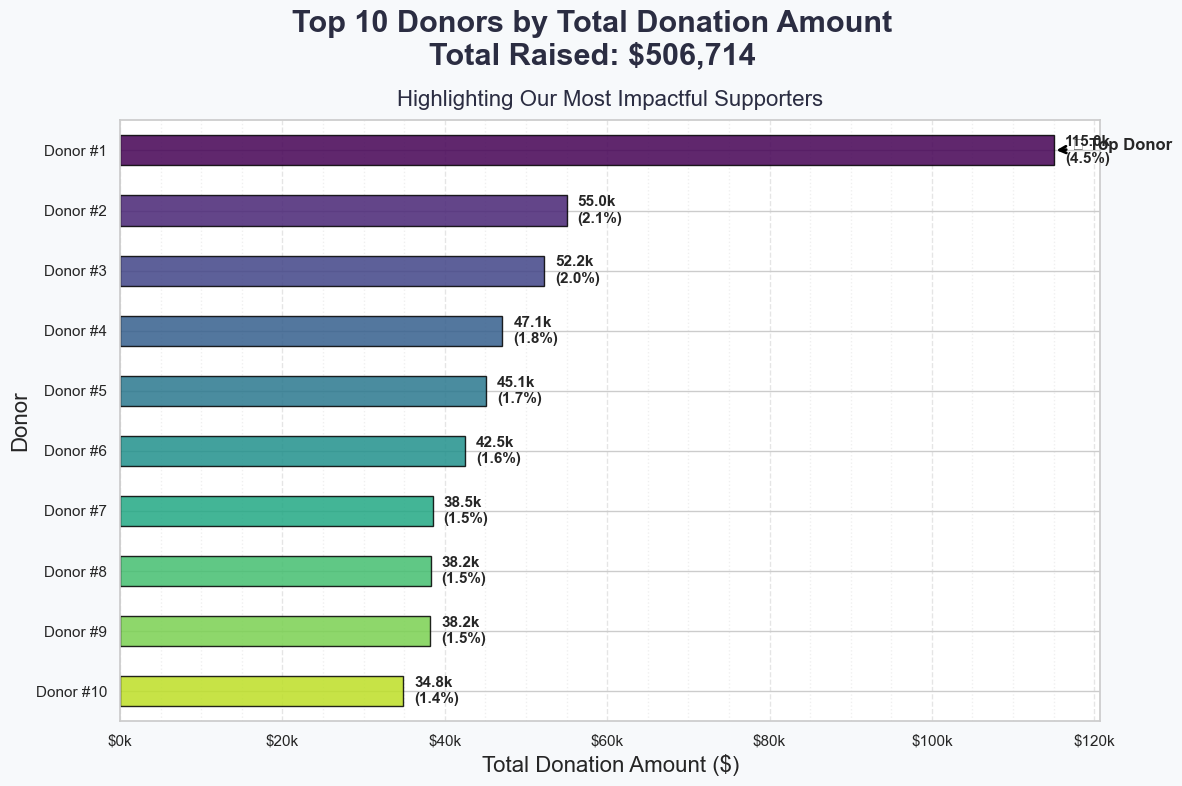

In [178]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import numpy as np

# --- Top Donors (Anonymized) ---

# Group and sort
top_donors = data.groupby('Account Number')['Revenue Amount'].sum().sort_values(ascending=False).head(10)

# Anonymize Donor IDs
anon_labels = [f"Donor #{i+1}" for i in range(len(top_donors))]
top_donors.index = anon_labels

# Total revenue for % calculation
total_revenue = data['Revenue Amount'].sum()

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Color Gradient
cmap = cm.get_cmap('viridis')
colors = [cmap(i/len(top_donors)) for i in range(len(top_donors))]

top_donors.plot(kind='barh', 
                color=colors, 
                edgecolor='black', 
                alpha=0.85, 
                ax=ax)

# Titles
total_top10 = top_donors.sum()
fig.suptitle(f'Top 10 Donors by Total Donation Amount\nTotal Raised: ${total_top10:,.0f}', 
             fontsize=22, fontweight='bold', color='#2b2d42')
ax.set_title('Highlighting Our Most Impactful Supporters', fontsize=16, color='#2b2d42', pad=10)

# Labels
ax.set_xlabel('Total Donation Amount ($)', fontsize=16)
ax.set_ylabel('Donor', fontsize=16)
ax.invert_yaxis()

# Format x-axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x*1e-3)}k'))

# Annotate bars with amount and % of total revenue
for p, value in zip(ax.patches, top_donors.values):
    percent = value / total_revenue * 100
    ax.annotate(f'{p.get_width()/1000:.1f}k\n({percent:.1f}%)', 
                (p.get_width(), p.get_y() + p.get_height()/2), 
                xytext=(8, 0), 
                textcoords='offset points', 
                ha='left', va='center', 
                fontsize=11, fontweight='bold')

# Highlight Top Donor separately
ax.annotate('🏆 Top Donor', 
            xy=(top_donors.values[0], 0), 
            xytext=(top_donors.values[0] * 1.02, 0), 
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color='black', lw=2), 
            fontsize=12, fontweight='bold')

# Minor ticks and grid
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.grid(axis='x', which='minor', linestyle=':', alpha=0.3)

# Styling
fig.patch.set_facecolor('#f7f9fb')

plt.tight_layout()
plt.show()


/var/folders/5z/4gjkw8xd2kvgg7xq7m8q8ct40000gn/T/ipykernel_83305/3946864851.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


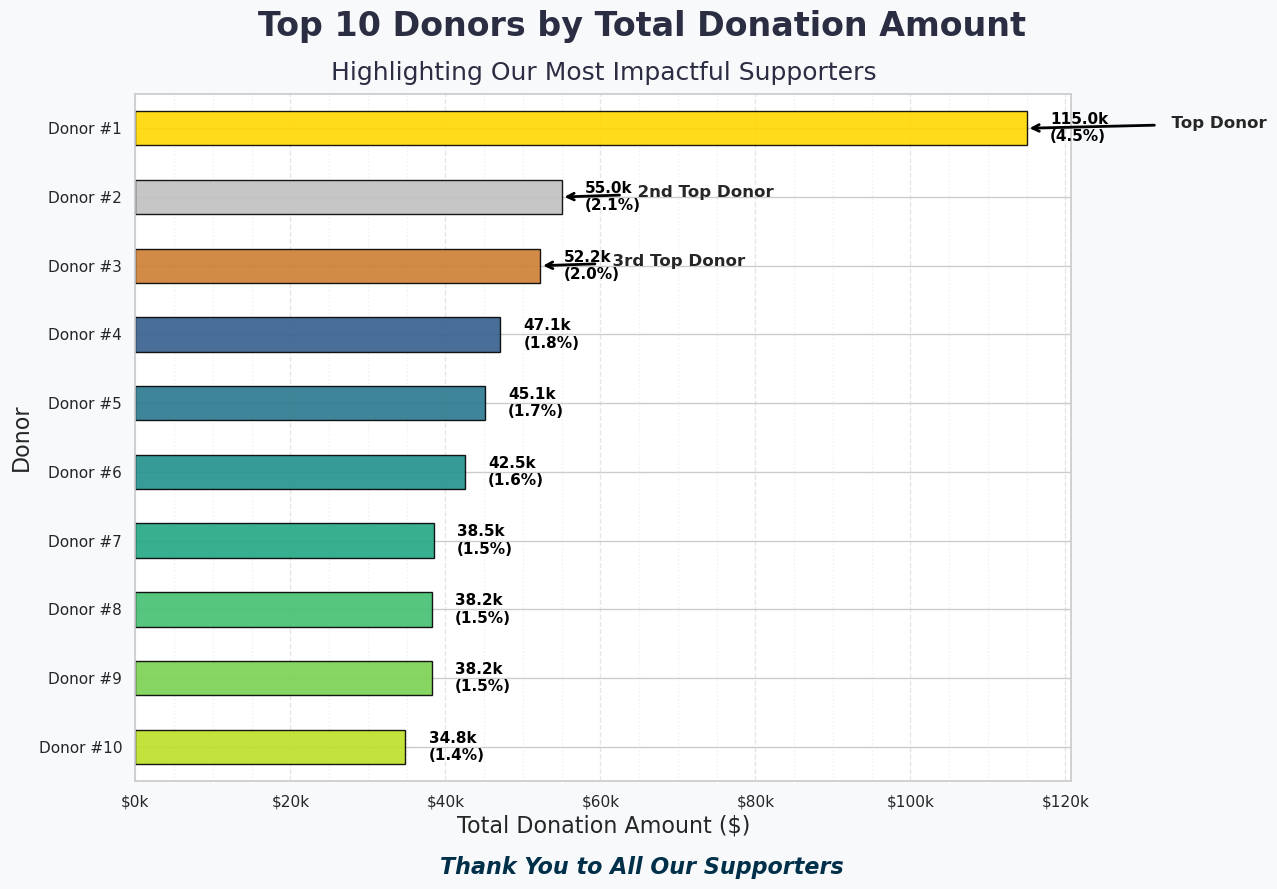

In [188]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import numpy as np

# --- Top Donors (Anonymized) ---

# Group and sort
top_donors = data.groupby('Account Number')['Revenue Amount'].sum().sort_values(ascending=False).head(10)

# Anonymize Donor IDs
anon_labels = [f"Donor #{i+1}" for i in range(len(top_donors))]
top_donors.index = anon_labels

# Total revenue for % calculation
total_revenue = data['Revenue Amount'].sum()

# Plot
fig, ax = plt.subplots(figsize=(13, 9))  # Make figure slightly taller

# Custom colors
cmap = cm.get_cmap('viridis')
colors = [cmap(i/len(top_donors)) for i in range(len(top_donors))]

# Override top 3 colors
special_colors = ['#FFD700', '#C0C0C0', '#CD7F32']  # Gold, Silver, Bronze
for i in range(3):
    colors[i] = special_colors[i]

# Plot
top_donors.plot(kind='barh', 
                color=colors, 
                edgecolor='black', 
                alpha=0.9, 
                ax=ax)

# Titles
fig.suptitle('Top 10 Donors by Total Donation Amount', 
             fontsize=24, fontweight='bold', color='#2b2d42')
ax.set_title('Highlighting Our Most Impactful Supporters', fontsize=18, color='#2b2d42', pad=10)

# Labels
ax.set_xlabel('Total Donation Amount ($)', fontsize=16)
ax.set_ylabel('Donor', fontsize=16)
ax.invert_yaxis()

# Format x-axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x*1e-3)}k'))

# Annotate bars with amount and % of total revenue
for idx, (p, value) in enumerate(zip(ax.patches, top_donors.values)):
    percent = value / total_revenue * 100
    ax.annotate(f'{p.get_width()/1000:.1f}k\n({percent:.1f}%)', 
                (p.get_width() + 3000, p.get_y() + p.get_height()/2), 
                ha='left', va='center', 
                fontsize=11, fontweight='bold', color='black')

# Highlight 🥇 🥈 🥉
badge_texts = ['  Top Donor', '  2nd Top Donor', '  3rd Top Donor']
for i in range(3):
    ax.annotate(badge_texts[i], 
                xy=(top_donors.values[i], i), 
                xytext=(top_donors.values[i] * 1.15, i), 
                textcoords='data',
                arrowprops=dict(arrowstyle="->", color='black', lw=2),
                fontsize=12, fontweight='bold')

# Minor ticks and grid
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.grid(axis='x', which='minor', linestyle=':', alpha=0.3)

# Styling
fig.patch.set_facecolor('#f7f9fb')

# --- 🏆 Add "Thank You" Banner ---
fig.text(0.5, 0.02, 'Thank You to All Our Supporters', 
         ha='center', fontsize=16, color='#003049', fontweight='bold', style='italic')

plt.tight_layout(rect=[0, 0.04, 1, 1])  # Leave space at bottom for banner
plt.show()


In [192]:
# --- 6. Summary Findings (Upgraded & Professional) ---

print("\n" + "="*60)
print("📊 SUMMARY FINDINGS 📊".center(60))
print("="*60)

# 1. Recurring vs One-Time Donations
print("\n🛎️ Recurring vs One-Time Donations:")
for donation_type, amount in recurring_summary.items():
    print(f"  - {donation_type}: ${amount:,.2f}")

# 2. Campaign vs Unprompted Donations
print("\n📢 Campaign vs Unprompted Donations:")
for campaign_type, amount in campaign_summary.items():
    print(f"  - {campaign_type}: ${amount:,.2f}")

# 3. Large vs Small Donations
print("\n💵 Donation Size Breakdown:")
print(f"  - Major Donations (> $500): ${large_donations.sum():,.2f}")
print(f"  - Smaller Donations (≤ $500): ${small_donations.sum():,.2f}")

# 4. Top 10 Donors
print("\n🏆 Top 10 Donors (Anonymized):")
for donor, amount in top_donors.items():
    print(f"  - {donor}: ${amount:,.2f}")

print("="*60)



                    📊 SUMMARY FINDINGS 📊                    

🛎️ Recurring vs One-Time Donations:
  - One-Time: $2,461,378.06
  - Recurring: $118,186.07

📢 Campaign vs Unprompted Donations:
  - Campaign: $2,137,504.44
  - Unprompted: $442,059.69

💵 Donation Size Breakdown:
  - Major Donations (> $500): $1,800,510.14
  - Smaller Donations (≤ $500): $779,053.99

🏆 Top 10 Donors (Anonymized):
  - Donor #1: $115,000.00
  - Donor #2: $55,000.00
  - Donor #3: $52,237.61
  - Donor #4: $47,088.88
  - Donor #5: $45,084.48
  - Donor #6: $42,500.00
  - Donor #7: $38,485.00
  - Donor #8: $38,250.00
  - Donor #9: $38,231.75
  - Donor #10: $34,836.70
